# ConvLM

A temporal convolutional language model is trained

In [1]:
# % load_ext autoreload
# % autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import pickle
import numpy as np
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
from torch import nn

In [3]:
from lm.data import LMDataLoader
from lm.models import ConvLM, accuracy, perplexity
from lm.schedulers import OneCycle

In [4]:
device = torch.device("cuda:0")
# device = torch.device('cpu')

Loading the data, making dataloaders

In [5]:
dict_path = Path('word2int.pickle')
with dict_path.open('rb') as file:
    d = pickle.load(file)

In [6]:
xtrain = np.load('wikitext_train_int_tokens.npy')
xval = np.load('wikitext_valtest_int_tokens.npy')

In [7]:
xtrain_tensor = torch.from_numpy(xtrain).long()
xval_tensor = torch.from_numpy(xval).long()

if device.type == 'cuda':
    xtrain_tensor = xtrain_tensor.cuda()
    xval_tensor = xval_tensor.cuda()

In [8]:
train_dataloader = LMDataLoader(xtrain_tensor, 70, 64)
val_dataloader = LMDataLoader(xval_tensor, 70, 64)

In [9]:
vocab_size = len(d)
padding_idx = d['_pad_']

In [10]:
embedding_dropout=0.1
num_blocks=3
kernel_size=2
num_layers=2

In [11]:
model = ConvLM(num_layers=num_layers, embedding_dropout=embedding_dropout, num_blocks=num_blocks, 
               vocab_size=vocab_size, kernel_size=kernel_size, padding_idx=padding_idx).cuda()

In [12]:
model

ConvLM(
  (embedding): VDEmbedding(
    (embedding): Embedding(30002, 400, padding_idx=0)
  )
  (TCNBlock_0): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(1,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(1,))
    )
  )
  (TCNBlock_1): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(2,), dilation=(2,))
    )
  )
  (TCNBlock_2): TCNBlock(
    (conv1): WDConv(
      (conv): Conv1d(400, 1150, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    )
    (conv2): WDConv(
      (conv): Conv1d(1150, 400, kernel_size=(2,), stride=(1,), padding=(4,), dilation=(4,))
    )
  )
  (decoder): Linear(in_features=400, out_features=30002, bias=True)
  (emb_drop): VariationalDropout()
)

Finally, define our losses

In [13]:
crit = nn.CrossEntropyLoss()

Now, a first round of training, to make sure everything actually works.

In [14]:
optimizer = torch.optim.Adam(model.parameters())

In [15]:
starting_learning_rate = 1e-5
ending_learning_rate = 1

info = defaultdict(list)

for batch_number, batch in (enumerate(tqdm(train_dataloader))):
    
    addition = (batch_number / len(train_dataloader)) * (ending_learning_rate - starting_learning_rate)
    learning_rate = starting_learning_rate + addition
    # update the optimizer learning rates
    for g in optimizer.param_groups:
        g['lr'] = learning_rate
    info['lr'].append(learning_rate)
    # Zero the gradients of my optimizer - 'reset' it
    optimizer.zero_grad()

    x, y = batch
    pred = model(x)

    loss = crit(pred, y)
    acc = accuracy(pred, y)

    info['loss'].append(loss.item())
    info['accuracy'].append(acc)
    
    loss.backward()
    optimizer.step()

 92%|█████████▏| 471/514 [00:50<00:04,  9.26it/s]


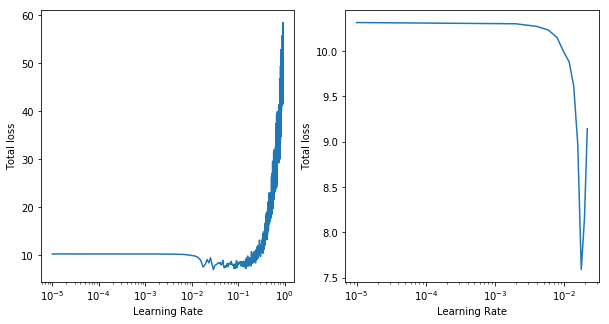

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10,5))

# First, lets plot the results from the whole test
axes[0].plot(info['lr'], info['loss'])
axes[0].set_xlabel('Learning Rate')
axes[0].set_ylabel('Total loss')
axes[0].set_xscale('log')

# then, clipped
axes[1].plot(info['lr'][:12], info['loss'][:12])
axes[1].set_xlabel('Learning Rate')
axes[1].set_ylabel('Total loss')
axes[1].set_xscale('log')

In [15]:
scheduler = OneCycle(optimizer, len(train_dataloader), upswing=2, downswing=18, min_lr=1e-5,
                     max_lr=1e-2)

In [16]:
num_epochs = scheduler.num_epochs()

In [18]:
overall_train = defaultdict(list)
overall_val = defaultdict(list)

for epoch in range(num_epochs):
    # set the model to train
    model.train()
    # keep track of training scores, so they can be displayed later
    train_scores = defaultdict(list)
    
    for batch_number, batch in (enumerate(tqdm(train_dataloader))):
        # Zero the gradients of my optimizer - 'reset' it
        optimizer.zero_grad()
        
        x, y = batch
        pred = model(x)
        
        loss = crit(pred, y)
        acc = accuracy(pred, y)
        
        train_scores['loss'].append(loss.item())
        train_scores['accuracy'].append(acc)
        train_scores['perplexity'].append(perplexity(loss))
        
        total_loss = loss
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
    train_output_strings = []
    for key, val in train_scores.items():
        mean_value = np.array(val).mean()
        train_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
        overall_train[key].append(mean_value)
        
    if val_dataloader:
        model.eval()
        val_scores = defaultdict(list)
        with torch.no_grad():
            for batch_number, batch in enumerate(val_dataloader):
                x, y = batch
                pred = model(x)
                val_loss = crit(pred, y)
                acc = accuracy(pred, y)
                
                val_scores['loss'].append(val_loss)
                val_scores['accuracy'].append(acc)
                val_scores['perplexity'].append(perplexity(val_loss))
                
        val_output_strings = []
        for key, val in val_scores.items():
            mean_value = np.array(val).mean()
            val_output_strings.append('{}: {}'.format(key, round(mean_value, 5)))
            overall_val[key].append(mean_value)
        print('TRAINING: {}, {}, {}'.format(*train_output_strings))
        print('VALIDATION: {}, {}, {}'.format(*val_output_strings))

  0%|          | 1/514 [00:00<01:22,  6.21it/s]

TRAINING: loss: 7.7578, accuracy: 0.05485
VALIDATION: loss: 6.898719787597656, accuracy: 0.0765


  0%|          | 1/514 [00:00<01:23,  6.17it/s]

TRAINING: loss: 7.24082, accuracy: 0.07793
VALIDATION: loss: 6.87598991394043, accuracy: 0.08289


  0%|          | 1/514 [00:00<01:18,  6.52it/s]

TRAINING: loss: 7.32725, accuracy: 0.0835
VALIDATION: loss: 6.849390029907227, accuracy: 0.09141


  0%|          | 1/514 [00:00<01:24,  6.09it/s]

TRAINING: loss: 7.31458, accuracy: 0.08587
VALIDATION: loss: 6.800350189208984, accuracy: 0.09389


  0%|          | 1/514 [00:00<01:19,  6.44it/s]

TRAINING: loss: 7.27546, accuracy: 0.0862
VALIDATION: loss: 6.910260200500488, accuracy: 0.09271


  0%|          | 1/514 [00:00<01:23,  6.16it/s]

TRAINING: loss: 7.2565, accuracy: 0.08569
VALIDATION: loss: 6.84004020690918, accuracy: 0.09346


  0%|          | 1/514 [00:00<01:20,  6.40it/s]

TRAINING: loss: 7.23133, accuracy: 0.08689
VALIDATION: loss: 6.814620018005371, accuracy: 0.08943


  0%|          | 1/514 [00:00<01:19,  6.45it/s]

TRAINING: loss: 7.1632, accuracy: 0.08671
VALIDATION: loss: 6.869939804077148, accuracy: 0.08774


  0%|          | 1/514 [00:00<01:23,  6.12it/s]

TRAINING: loss: 7.19864, accuracy: 0.08712
VALIDATION: loss: 6.877610206604004, accuracy: 0.09463


  0%|          | 1/514 [00:00<01:22,  6.20it/s]

TRAINING: loss: 7.14562, accuracy: 0.08736
VALIDATION: loss: 6.837029933929443, accuracy: 0.09284


  0%|          | 1/514 [00:00<01:19,  6.48it/s]

TRAINING: loss: 7.12527, accuracy: 0.08439
VALIDATION: loss: 6.824319839477539, accuracy: 0.09433


  0%|          | 1/514 [00:00<01:21,  6.29it/s]

TRAINING: loss: 7.05062, accuracy: 0.08867
VALIDATION: loss: 6.8538498878479, accuracy: 0.09702


  0%|          | 1/514 [00:00<01:20,  6.37it/s]

TRAINING: loss: 7.08358, accuracy: 0.08855
VALIDATION: loss: 6.854640007019043, accuracy: 0.08765


  0%|          | 1/514 [00:00<01:19,  6.45it/s]

TRAINING: loss: 7.0674, accuracy: 0.08859
VALIDATION: loss: 6.838019847869873, accuracy: 0.08894


  0%|          | 1/514 [00:00<01:23,  6.11it/s]

TRAINING: loss: 7.05376, accuracy: 0.08883
VALIDATION: loss: 6.852240085601807, accuracy: 0.08738


  0%|          | 1/514 [00:00<01:21,  6.28it/s]

TRAINING: loss: 7.07382, accuracy: 0.08692
VALIDATION: loss: 6.7896199226379395, accuracy: 0.09598


  0%|          | 1/514 [00:00<01:22,  6.25it/s]

TRAINING: loss: 7.04725, accuracy: 0.08883
VALIDATION: loss: 6.831140041351318, accuracy: 0.09509


  0%|          | 1/514 [00:00<01:23,  6.15it/s]

TRAINING: loss: 7.05571, accuracy: 0.09069
VALIDATION: loss: 6.8021697998046875, accuracy: 0.09773


  0%|          | 1/514 [00:00<01:20,  6.37it/s]

TRAINING: loss: 7.03671, accuracy: 0.0916
VALIDATION: loss: 6.834109783172607, accuracy: 0.0936


 91%|█████████▏| 470/514 [01:12<00:06,  6.46it/s]


TRAINING: loss: 7.05627, accuracy: 0.09039
VALIDATION: loss: 6.768249988555908, accuracy: 0.10324


In [19]:
model_information = {'state_dict': model.state_dict(),
                     'val_acc': overall_val['accuracy'],
                      'val_loss': overall_val['loss'],
                      'train_acc': overall_train['accuracy'],
                    'train_loss': overall_train['loss'],
                    'num_blocks': num_blocks,
                    'embedding_dropout': embedding_dropout,
                    'kernel_size': kernel_size,
                    'num_layers': num_layers}
torch.save(model_information, 'ConvLM_B3_L2_K2.pth.tar')

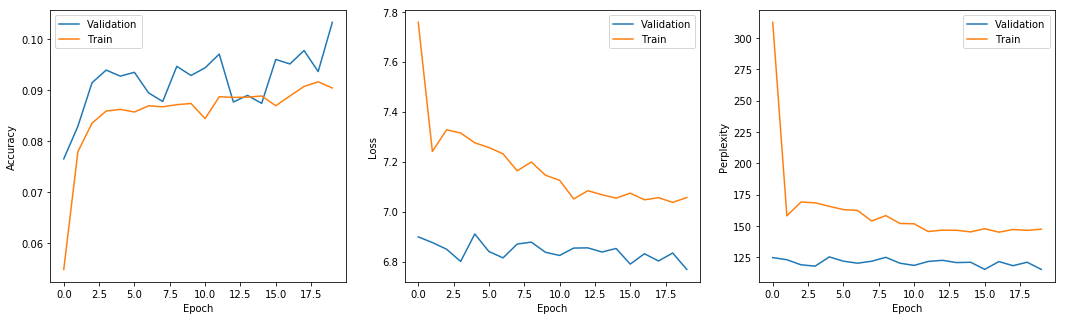

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))

# First, lets plot accuracy
axes[0].plot(range(len(overall_val['accuracy'])), overall_val['accuracy'], label='Validation')
axes[0].plot(range(len(overall_train['accuracy'])), overall_train['accuracy'], label='Train')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

# then, loss
axes[1].plot(range(len(overall_val['loss'])), overall_val['loss'], label='Validation')
axes[1].plot(range(len(overall_train['loss'])), overall_train['loss'], label='Train')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

# finally, perplexity
axes[2].plot(range(len(overall_val['perplexity'])), overall_val['perplexity'], label='Validation')
axes[2].plot(range(len(overall_train['perplexity'])), overall_train['perplexity'], label='Train')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('Perplexity')
axes[2].legend()